In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
df, df_labs = mnist['data'], mnist['target']

In [8]:
df_train, df_test, df_labs_train, df_labs_test = df[:60000], df[60000:], df_labs[:60000], df_labs[60000:]

In [22]:
df_labs_train_5 = (df_labs_train == '5')*1

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [30]:
cv_m = cross_val_score(SGDClassifier(random_state=42), X=df_train, y=df_labs_train_5,scoring='accuracy', cv=3)

In [31]:
cv_m

array([0.95035, 0.96035, 0.9604 ])

In [32]:
from sklearn.model_selection import cross_val_predict

In [37]:
prevs = cross_val_predict(SGDClassifier(random_state=42), X=df_train, y=df_labs_train_5, cv=3)

In [38]:
from sklearn.metrics import confusion_matrix

In [40]:
confusion_matrix(df_labs_train_5, prevs)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, plot_precision_recall_curve

In [43]:
precision_score(df_labs_train_5, prevs)

0.8370879772350012

In [44]:
recall_score(df_labs_train_5, prevs)

0.6511713705958311

In [45]:
f1_score(df_labs_train_5, prevs)

0.7325171197343846

In [53]:
decs = cross_val_predict(SGDClassifier(random_state=42), X=df_train, y=df_labs_train_5, cv=3, method='decision_function')

In [59]:
prec, rec, thresh = precision_recall_curve(df_labs_train_5, decs)

(-50000.0, 50000.0)

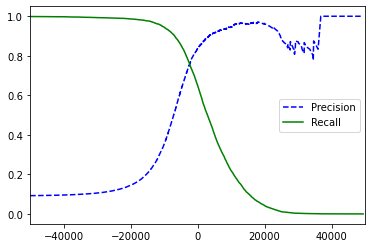

In [85]:
plt.plot(thresh, prec[:-1], 'b--', label='Precision')
plt.plot(thresh, rec[:-1], 'g-', label='Recall')
plt.legend()
plt.xlim([-50000, 50000])

Text(0, 0.5, 'Precision')

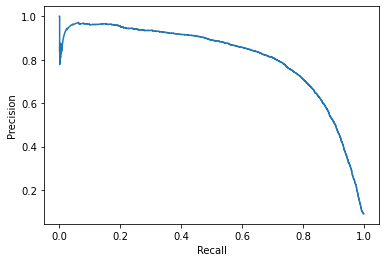

In [88]:
plt.plot(rec[:-1], prec[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score

In [92]:
fpr, tpr, thresh = roc_curve(df_labs_train_5, decs)

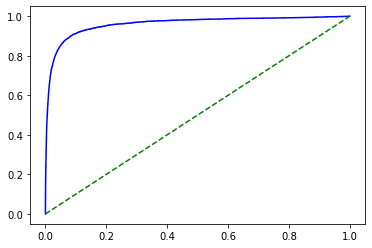

In [100]:
plt.plot(fpr, tpr, 'b-')
plt.plot([0,1], [0,1], 'g--')

In [101]:
roc_auc_score(df_labs_train_5, decs)

0.9604938554008616

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
from sklearn.preprocessing import StandardScaler

In [108]:
from sklearn.pipeline import Pipeline

In [155]:
kn = Pipeline([
    ('Standardize', StandardScaler()),
    ('Model', KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1))
])

In [128]:
from sklearn.model_selection import GridSearchCV

In [142]:
params = {
    'Model__weights':['distance'],
    'Model__n_neighbors':[3,4,5]
}

In [143]:
grid = GridSearchCV(kn, param_grid=params, cv=3, scoring='accuracy', verbose=10)

In [159]:
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(df_train, df_labs_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [161]:
prev = knn_clf.predict(df_test)

In [186]:
np.mean(prev == df_labs_test)

0.9714

In [224]:
from scipy.ndimage.interpolation import shift

In [189]:
pit = df_train.loc[0]

In [197]:
pit_n = pit.values.reshape((28,28))

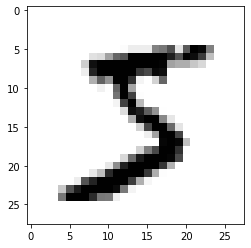

In [226]:
plt.imshow(pit_n, cmap='binary')

In [246]:
def shift_img(img, dx, dy):
    nv = img.values.reshape(28,28)
    nv = shift(nv, [dy, dx], cval=0, mode='constant')
    return nv.reshape([-1])

In [279]:
def create_imgs(img):
    im = [img]
    for dx, dy in [(1,0),(0,1), (-1,0), (0, -1)]:
        im.append(shift_img(img, dx, dy))
    return im

In [286]:
df_train_nv = []
df_labs_train_nv = []

for im in range(len(df_train)):
    df_train_nv.extend(create_imgs(df_train.iloc[im]))
    df_labs_train_nv.extend(5*list(df_labs_train.iloc[im]))


In [291]:
df_train_nv = pd.DataFrame(np.array(df_train_nv))
df_labs_train_nv = pd.DataFrame(np.array(df_labs_train_nv))

In [297]:
df_labs_train_nv = df_labs_train_nv.astype(int)

In [300]:
kn = KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [310]:
indx = np.random.permutation(range(0,len(df_train_nv)))

In [312]:
kn.fit(df_train_nv.iloc[indx].values, df_labs_train_nv.iloc[indx][0].values)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [316]:
prevs = kn.predict(df_test)

In [320]:
prevs

array([7, 2, 1, ..., 4, 5, 6])

In [322]:
np.mean(prevs == df_labs_test.astype(int).values)

0.9763